# Sign Language digit classification using RNN

Dataset: https://www.kaggle.com/ardamavi/sign-language-digits-dataset

Hint: Recurrent Neural Network for image classification

In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset

In [2]:
from os import listdir
from os.path import isfile, join
import imageio
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Step 1. Preprocess the data as per the given task

In [3]:
#download dataset containing 10 folders with images of sign digits from 0 to 9

### Step 2. Write custom dataloader and collate function for creating train dataset and test dataset

In [4]:
path_images = './Dataset/'

class SignDataset(Dataset):
    def __init__(self, root_dir):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.image_files = self._find_files()
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        elements = list(self.image_files.items())
        #print(elements[index][0])
        image = io.imread(elements[index][0])
        label = torch.tensor(int(elements[index][1]))
        return (image, label)
    
    
    def _find_files(self):
        """Recursively finds all files matching the pattern."""
        files = {}
        for i in range(0,9):
            images = [f for f in listdir(self.root_dir+'/'+str(i)) if isfile(join(self.root_dir+'/'+str(i), f))]
            for el in images:
                files[self.root_dir+str(i)+'/'+el] = i
        return files

In [5]:
class SignCollate(object):
    """Function object used as a collate function for DataLoader."""

    def __init__(self, ):
        
        pass
        

    def _collate_fn(self, batch):
        new_batch = []
        for idx in range(len(batch)):
            sample = batch[idx][0]
            label = batch[idx][1]
            new_batch.append(sample)

        # scalar output
        sample_batch = np.array(new_batch)
        sample_batch = torch.FloatTensor(sample_batch)
        #print(sample_batch)
        return sample_batch

    def __call__(self, batch):
        return self._collate_fn(batch)

In [6]:
dataset = SignDataset(root_dir=path_images)
dataset

collate_fn = SignCollate()

batch_size = 32

#dataloader = DataLoader(dataset, batch_size=batch_size,shuffle=True, num_workers=0, collate_fn=collate_fn, pin_memory=True)

In [7]:
# for x in dataloader:
#     print(x.shape)
#     x_np = x.numpy()
#     plt.imshow(x_np[0][:,:,1])
#     plt.show()
#     plt.pause(0.001)

In [8]:
#Split into TRAIN and TEST
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [9]:
#print(train_loader)

In [10]:
#for i, (x,y) in enumerate(train_dataset):
    #print(x)

In [11]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [12]:
#print(train_loader.shape)

### Step 3. Define the neural network model in pytorch

In [13]:
# Devise configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
# Recurrent neural network (many-to-one)
class RNN_LSTM_classifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, num_direction=1):
        super(RNN_LSTM_classifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_direction = num_direction
        
        if self.num_direction == 1:
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=False)
        else:
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        
        # batch_size x seq_len x input_size
        # Forward propagate LSTM
        out, _ = self.lstm(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

### Step 4. Define hyperparameters to create instance of neural network model as well as parameters required to train neural network

In [30]:
# Hyper-parameters
sequence_length = 300
input_size = 100
hidden_size = 64
num_layers = 2
num_classes = 10
num_epochs = 500
learning_rate = 0.01

# Hyperparameters

In [31]:
model = RNN_LSTM_classifier(input_size, hidden_size, num_layers, num_classes).to(device)

In [32]:
model

RNN_LSTM_classifier(
  (lstm): LSTM(100, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=10, bias=True)
)

In [33]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Step 5. Write training loop for training the model

In [ ]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        #print(images.shape, labels.shape)
        #images = images.view(-1, sequence_length, input_size)
        #print(images.shape, labels.shape)
        
        # Forward pass
        outputs = model(images.float())
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/500], Step [10/53], Loss: 2.1943
Epoch [1/500], Step [20/53], Loss: 2.1972
Epoch [1/500], Step [30/53], Loss: 2.1981
Epoch [1/500], Step [40/53], Loss: 2.2004
Epoch [1/500], Step [50/53], Loss: 2.1837
Epoch [2/500], Step [10/53], Loss: 2.2128
Epoch [2/500], Step [20/53], Loss: 2.2089
Epoch [2/500], Step [30/53], Loss: 2.2122
Epoch [2/500], Step [40/53], Loss: 2.2301
Epoch [2/500], Step [50/53], Loss: 2.2329
Epoch [3/500], Step [10/53], Loss: 2.2240
Epoch [3/500], Step [20/53], Loss: 2.2561
Epoch [3/500], Step [30/53], Loss: 2.1928
Epoch [3/500], Step [40/53], Loss: 2.2209
Epoch [3/500], Step [50/53], Loss: 2.2278
Epoch [4/500], Step [10/53], Loss: 2.2272
Epoch [4/500], Step [20/53], Loss: 2.1958
Epoch [4/500], Step [30/53], Loss: 2.2156
Epoch [4/500], Step [40/53], Loss: 2.2096
Epoch [4/500], Step [50/53], Loss: 2.2139
Epoch [5/500], Step [10/53], Loss: 2.2165
Epoch [5/500], Step [20/53], Loss: 2.2159
Epoch [5/500], Step [30/53], Loss: 2.1954
Epoch [5/500], Step [40/53], Loss:

Epoch [39/500], Step [30/53], Loss: 2.1854
Epoch [39/500], Step [40/53], Loss: 2.1991
Epoch [39/500], Step [50/53], Loss: 2.2063
Epoch [40/500], Step [10/53], Loss: 2.2113
Epoch [40/500], Step [20/53], Loss: 2.2005
Epoch [40/500], Step [30/53], Loss: 2.2092
Epoch [40/500], Step [40/53], Loss: 2.2073
Epoch [40/500], Step [50/53], Loss: 2.1971
Epoch [41/500], Step [10/53], Loss: 2.1939
Epoch [41/500], Step [20/53], Loss: 2.1972
Epoch [41/500], Step [30/53], Loss: 2.2152
Epoch [41/500], Step [40/53], Loss: 2.2017
Epoch [41/500], Step [50/53], Loss: 2.2024
Epoch [42/500], Step [10/53], Loss: 2.2019
Epoch [42/500], Step [20/53], Loss: 2.2144
Epoch [42/500], Step [30/53], Loss: 2.2122
Epoch [42/500], Step [40/53], Loss: 2.2008
Epoch [42/500], Step [50/53], Loss: 2.2060
Epoch [43/500], Step [10/53], Loss: 2.1901
Epoch [43/500], Step [20/53], Loss: 2.2063
Epoch [43/500], Step [30/53], Loss: 2.1915
Epoch [43/500], Step [40/53], Loss: 2.1996
Epoch [43/500], Step [50/53], Loss: 2.1956
Epoch [44/5

Epoch [77/500], Step [40/53], Loss: 2.1990
Epoch [77/500], Step [50/53], Loss: 2.2022
Epoch [78/500], Step [10/53], Loss: 2.1998
Epoch [78/500], Step [20/53], Loss: 2.1873
Epoch [78/500], Step [30/53], Loss: 2.2067
Epoch [78/500], Step [40/53], Loss: 2.1947
Epoch [78/500], Step [50/53], Loss: 2.1997
Epoch [79/500], Step [10/53], Loss: 2.1951
Epoch [79/500], Step [20/53], Loss: 2.1925
Epoch [79/500], Step [30/53], Loss: 2.1977
Epoch [79/500], Step [40/53], Loss: 2.1948
Epoch [79/500], Step [50/53], Loss: 2.1951
Epoch [80/500], Step [10/53], Loss: 2.1871
Epoch [80/500], Step [20/53], Loss: 2.1982
Epoch [80/500], Step [30/53], Loss: 2.2126
Epoch [80/500], Step [40/53], Loss: 2.1917
Epoch [80/500], Step [50/53], Loss: 2.2095
Epoch [81/500], Step [10/53], Loss: 2.1880
Epoch [81/500], Step [20/53], Loss: 2.1965
Epoch [81/500], Step [30/53], Loss: 2.2075
Epoch [81/500], Step [40/53], Loss: 2.2000
Epoch [81/500], Step [50/53], Loss: 2.1979
Epoch [82/500], Step [10/53], Loss: 2.1858
Epoch [82/5

Epoch [115/500], Step [30/53], Loss: 2.2052
Epoch [115/500], Step [40/53], Loss: 2.2090
Epoch [115/500], Step [50/53], Loss: 2.2032
Epoch [116/500], Step [10/53], Loss: 2.2086
Epoch [116/500], Step [20/53], Loss: 2.2077
Epoch [116/500], Step [30/53], Loss: 2.1922
Epoch [116/500], Step [40/53], Loss: 2.2023
Epoch [116/500], Step [50/53], Loss: 2.2080
Epoch [117/500], Step [10/53], Loss: 2.1994
Epoch [117/500], Step [20/53], Loss: 2.1973
Epoch [117/500], Step [30/53], Loss: 2.1968
Epoch [117/500], Step [40/53], Loss: 2.2112
Epoch [117/500], Step [50/53], Loss: 2.1989
Epoch [118/500], Step [10/53], Loss: 2.1910
Epoch [118/500], Step [20/53], Loss: 2.1819
Epoch [118/500], Step [30/53], Loss: 2.1950
Epoch [118/500], Step [40/53], Loss: 2.1986
Epoch [118/500], Step [50/53], Loss: 2.1892
Epoch [119/500], Step [10/53], Loss: 2.1854
Epoch [119/500], Step [20/53], Loss: 2.1795
Epoch [119/500], Step [30/53], Loss: 2.2032
Epoch [119/500], Step [40/53], Loss: 2.1956
Epoch [119/500], Step [50/53], L

Epoch [152/500], Step [50/53], Loss: 2.2134
Epoch [153/500], Step [10/53], Loss: 2.1995
Epoch [153/500], Step [20/53], Loss: 2.2075
Epoch [153/500], Step [30/53], Loss: 2.1969
Epoch [153/500], Step [40/53], Loss: 2.1968
Epoch [153/500], Step [50/53], Loss: 2.1990
Epoch [154/500], Step [10/53], Loss: 2.1906
Epoch [154/500], Step [20/53], Loss: 2.1867
Epoch [154/500], Step [30/53], Loss: 2.1933
Epoch [154/500], Step [40/53], Loss: 2.1903
Epoch [154/500], Step [50/53], Loss: 2.1941
Epoch [155/500], Step [10/53], Loss: 2.1937
Epoch [155/500], Step [20/53], Loss: 2.1981
Epoch [155/500], Step [30/53], Loss: 2.1978
Epoch [155/500], Step [40/53], Loss: 2.1918
Epoch [155/500], Step [50/53], Loss: 2.2003
Epoch [156/500], Step [10/53], Loss: 2.1929
Epoch [156/500], Step [20/53], Loss: 2.1953
Epoch [156/500], Step [30/53], Loss: 2.1835
Epoch [156/500], Step [40/53], Loss: 2.2020
Epoch [156/500], Step [50/53], Loss: 2.1971
Epoch [157/500], Step [10/53], Loss: 2.2105
Epoch [157/500], Step [20/53], L

Epoch [190/500], Step [20/53], Loss: 2.1867
Epoch [190/500], Step [30/53], Loss: 2.1907
Epoch [190/500], Step [40/53], Loss: 2.1896
Epoch [190/500], Step [50/53], Loss: 2.2044
Epoch [191/500], Step [10/53], Loss: 2.2108
Epoch [191/500], Step [20/53], Loss: 2.2046
Epoch [191/500], Step [30/53], Loss: 2.2048
Epoch [191/500], Step [40/53], Loss: 2.1914
Epoch [191/500], Step [50/53], Loss: 2.2280
Epoch [192/500], Step [10/53], Loss: 2.1926
Epoch [192/500], Step [20/53], Loss: 2.1983
Epoch [192/500], Step [30/53], Loss: 2.2007
Epoch [192/500], Step [40/53], Loss: 2.1995
Epoch [192/500], Step [50/53], Loss: 2.1938
Epoch [193/500], Step [10/53], Loss: 2.1965
Epoch [193/500], Step [20/53], Loss: 2.1910
Epoch [193/500], Step [30/53], Loss: 2.1938
Epoch [193/500], Step [40/53], Loss: 2.1957
Epoch [193/500], Step [50/53], Loss: 2.1998
Epoch [194/500], Step [10/53], Loss: 2.1806
Epoch [194/500], Step [20/53], Loss: 2.2007
Epoch [194/500], Step [30/53], Loss: 2.1927
Epoch [194/500], Step [40/53], L

Epoch [227/500], Step [40/53], Loss: 2.1982
Epoch [227/500], Step [50/53], Loss: 2.2006
Epoch [228/500], Step [10/53], Loss: 2.2055
Epoch [228/500], Step [20/53], Loss: 2.1965
Epoch [228/500], Step [30/53], Loss: 2.1971
Epoch [228/500], Step [40/53], Loss: 2.2047
Epoch [228/500], Step [50/53], Loss: 2.1975
Epoch [229/500], Step [10/53], Loss: 2.1997
Epoch [229/500], Step [20/53], Loss: 2.1905
Epoch [229/500], Step [30/53], Loss: 2.1951
Epoch [229/500], Step [40/53], Loss: 2.1912
Epoch [229/500], Step [50/53], Loss: 2.1986
Epoch [230/500], Step [10/53], Loss: 2.1980
Epoch [230/500], Step [20/53], Loss: 2.1878
Epoch [230/500], Step [30/53], Loss: 2.1993


### Step 6. Evaluate the model on test data. In this part, it is expected to choose appropriate evaluation metrics based on your task. For an instance, for classification task, accuracy, precision and recall should be computed

In [20]:
# Test the model
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images.float())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total)) 

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model on the 10000 test images: 11.827956989247312 %


torch.Size([32, 100, 100, 3])


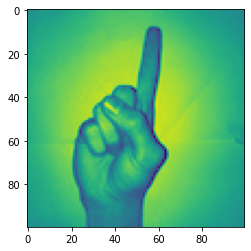

torch.Size([32, 3, 10000])
Predicted label:  tensor(1)
Correct label:  tensor(1)
torch.Size([32, 100, 100, 3])


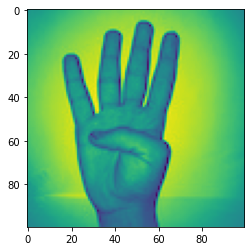

torch.Size([32, 3, 10000])
Predicted label:  tensor(1)
Correct label:  tensor(4)
torch.Size([32, 100, 100, 3])


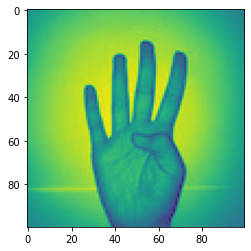

torch.Size([32, 3, 10000])
Predicted label:  tensor(1)
Correct label:  tensor(7)
torch.Size([32, 100, 100, 3])


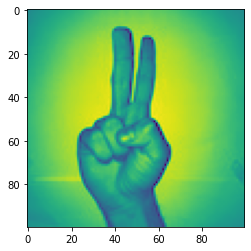

torch.Size([32, 3, 10000])
Predicted label:  tensor(1)
Correct label:  tensor(7)
torch.Size([32, 100, 100, 3])


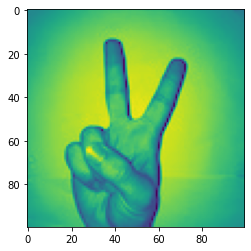

torch.Size([32, 3, 10000])
Predicted label:  tensor(1)
Correct label:  tensor(8)
torch.Size([26, 100, 100, 3])


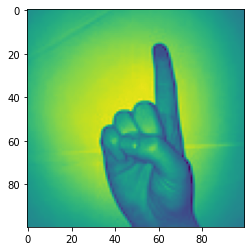

torch.Size([26, 3, 10000])
Predicted label:  tensor(1)
Correct label:  tensor(4)


In [21]:
for i, (images, labels) in enumerate(test_loader):
    print(images.shape)
    x_np = images.numpy()
    plt.imshow(x_np[0][:,:,1])
    plt.show()
    images = images.reshape(-1, sequence_length, input_size).to(device)
    outputs = model(images.float())
    _, predicted = torch.max(outputs.data, 1)
    print(images.shape)
    print('Predicted label: ', predicted[i])
    print('Correct label: ', labels[i])

### Step 7. Save the obtained results

In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

In [23]:
in_dir = './orignal/'
out_dir = './output/'

if os.path.exists(in_dir) == False:
    os.mkdir(in_dir)
    
if os.path.exists(out_dir) == False:
    os.mkdir(out_dir)

In [24]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        images = images.reshape(-1, sequence_length, input_size).to(device) # reshape the image,
        
        # forward pass
        outputs = model(images.float())
        
        #print(images.shape, outputs.shape)
        
        sample_image = images[0]
        sample_pred_image = outputs[0]
        #print(sample_image.shape, sample_pred_image.shape)
        
        sample_image = sample_image.view(100, 100, 3)
        sample_pred_image = sample_pred_image.view(100, 100, 3)
        
        #print(sample_image.numpy().shape)
        plt.imsave(os.path.join(in_dir, 'sample_%d.png'%i), sample_image.numpy() )
        plt.imsave(os.path.join(out_dir, 'sample_%d.png'%i), sample_pred_image.numpy())
        
        #imgplot = plt.imshow(sample_image.numpy())
        

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

RuntimeError: shape '[100, 100, 3]' is invalid for input of size 10